<a href="https://www.kaggle.com/code/achmadnoer/digit-recognizer-with-cnn-data-augmentation?scriptVersionId=95863241" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Table of Content

* **Data preparation**
    * Load dataset
    * Split dataset
    
* **Deep Learning - CNN**
    * Data augmentation
    * Create CNN model
    * Model training

* **Evaluate**
    * History chart
    * Confusion Matrix
    * Performance test

* **Submission**


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# Data Preparation

## Load datasets

In [2]:
train_data = pd.read_csv('../input/digit-recognizer/train.csv')
test_data = pd.read_csv('../input/digit-recognizer/test.csv')
submission_data = pd.read_csv('../input/digit-recognizer/sample_submission.csv')

In [3]:
print(f"train.csv size is {train_data.shape}")
print(f"test.csv size is {test_data.shape}")

train.csv size is (42000, 785)
test.csv size is (28000, 784)


In [4]:
X = train_data.drop(['label'], axis=1).values
y = train_data['label'].values

In [5]:
from keras.utils.np_utils import to_categorical

X = X.reshape(-1,28,28,1)
y = to_categorical(y)

## Split dataset

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42) #ratio 90:10

In [7]:
print(f"Training data size is {X_train.shape}")
print(f"Testing data size is {X_test.shape}")

Training data size is (37800, 28, 28, 1)
Testing data size is (4200, 28, 28, 1)


# Deep Learning - CNN

## Data augmentation

In [8]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    fill_mode='nearest',
    rescale=1./255,
)

In [9]:
train_gen = datagen.flow(X_train, y_train, batch_size = 64)
test_gen = datagen.flow(X_test, y_test, batch_size = 64)

## Create CNN model

In [10]:
import keras

model = keras.models.Sequential([
    keras.layers.Conv2D(16, (3,3), padding = 'same', activation='relu', input_shape=(28, 28, 1)),
    keras.layers.Conv2D(32, (3,3), padding = 'same', activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(32, (3,3), padding = 'same', activation='relu'),
    keras.layers.Conv2D(64, (3,3), padding = 'same', activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(64, (3,3), padding = 'same', activation='relu'),
    keras.layers.Conv2D(128, (3,3), padding = 'same', activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(128, (3,3), padding = 'same', activation='relu'),
    keras.layers.Conv2D(256, (3,3), padding = 'same', activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Dropout(0.2),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

2022-05-17 14:40:21.586023: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [11]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

## Model training

In [12]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=5,
    verbose=1,
    mode='max',
    min_delta=0.0001,
    min_lr=0.000001
)

In [13]:
batch_size = 64
train_steps = len(X_train) / batch_size
test_steps = len(X_test) / batch_size

history = model.fit(
    train_gen,
    validation_data = test_gen,
    epochs = 100, 
    steps_per_epoch = train_steps,
    validation_steps = test_steps,
    callbacks=[es, lr],
    verbose=1
)

print("\n[INFO] Train Accuracy:", "{:.5f}%".format(history.history['accuracy'][-1]*100))
print("[INFO] Train Loss    :", "{:.7f}".format(history.history['loss'][-1]))
print("[INFO] Test Accuracy  :", "{:.5f}%".format(history.history['val_accuracy'][-1]*100))
print("[INFO] Test Loss      :", "{:.7f}".format(history.history['val_loss'][-1]))

2022-05-17 14:40:22.188823: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
590/590 [==============================] - 73s 122ms/step - loss: 0.3431 - accuracy: 0.8871 - val_loss: 0.0695 - val_accuracy: 0.9798
Epoch 2/100
590/590 [==============================] - 70s 118ms/step - loss: 0.0981 - accuracy: 0.9707 - val_loss: 0.0678 - val_accuracy: 0.9819
Epoch 3/100
590/590 [==============================] - 70s 118ms/step - loss: 0.0741 - accuracy: 0.9785 - val_loss: 0.0361 - val_accuracy: 0.9890
Epoch 4/100
590/590 [==============================] - 68s 115ms/step - loss: 0.0618 - accuracy: 0.9823 - val_loss: 0.0437 - val_accuracy: 0.9888
Epoch 5/100
590/590 [==============================] - 70s 118ms/step - loss: 0.0551 - accuracy: 0.9839 - val_loss: 0.0641 - val_accuracy: 0.9814
Epoch 6/100
590/590 [==============================] - 71s 120ms/step - loss: 0.0539 - accuracy: 0.9848 - val_loss: 0.0450 - val_accuracy: 0.9890
Epoch 7/100
590/590 [==============================] - 71s 120ms/step - loss: 0.0461 - accuracy: 0.9866 - val_loss: 0.0546 -

# Evaluate

In [14]:
evaluate_test = model.evaluate(X_test, y_test, verbose=1)

print("\nAccuracy =", "{:.7f}%".format(evaluate_test[1]*100))
print("Loss     =" ,"{:.9f}".format(evaluate_test[0]))

132/132 [==============================] - 2s 16ms/step - loss: 4.3377 - accuracy: 0.9921

Accuracy = 99.2142856%
Loss     = 4.337673187


## History chart

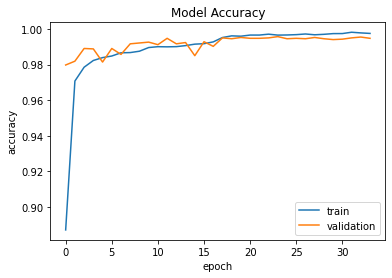

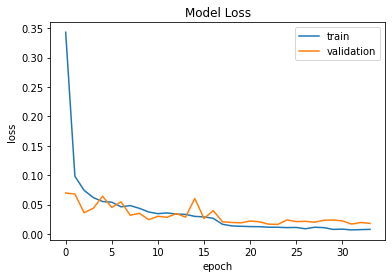

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()

## Confusion matrix

In [16]:
new_X_test = X_test.reshape(len(X_test),28,28,1) / 255.0
new_y_test = np.argmax(y_test, axis=-1)
yhat_test = np.argmax(model.predict(X_test), axis=-1)

<AxesSubplot:>

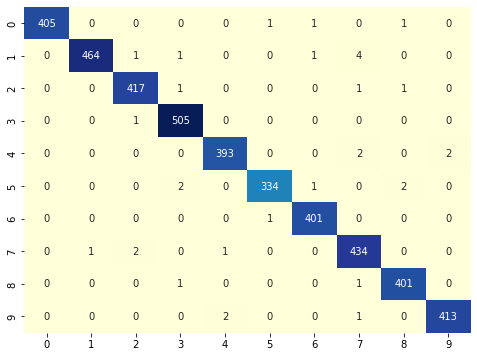

In [17]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(new_y_test, yhat_test)
df_cm = pd.DataFrame(conf_matrix,
                     index = range(0,10),
                     columns = range(0,10))
plt.figure(figsize = (8,6)) #ratio 4:3
sn.heatmap(df_cm, cmap="YlGnBu", fmt="d", cbar=False, annot=True)

## Performance test

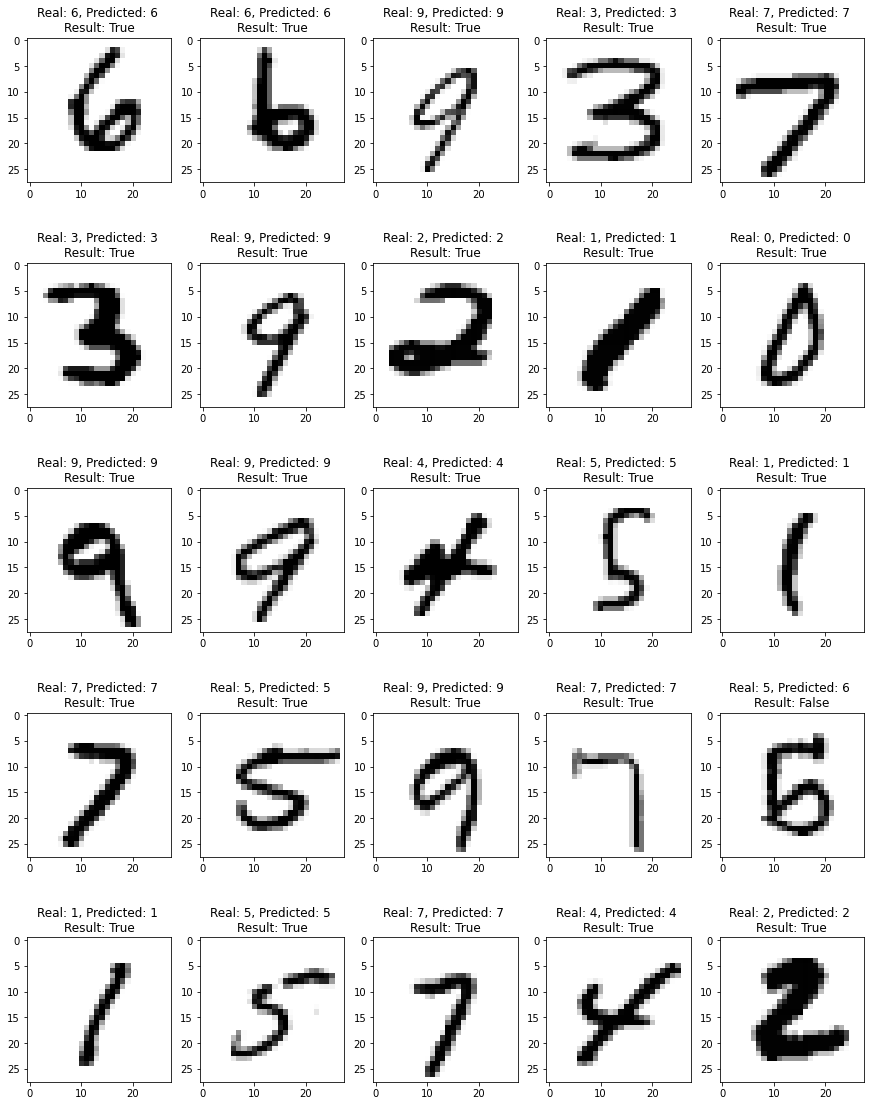

In [18]:
fig = plt.figure(figsize=(15,20)) #ratio 3:4
for pick_random in range(1,26):
    roll_number = np.random.randint(0, len(X_test)-1)
    output_result = (new_y_test[roll_number] == yhat_test[roll_number])
    
    fig.add_subplot(5, 5, pick_random)
    plt.title(f"Real: {new_y_test[roll_number]}, Predicted: {yhat_test[roll_number]} \nResult: {output_result}")
    plt.imshow(new_X_test[roll_number], cmap="binary")

# Submission

In [19]:
submission_label = np.argmax(model.predict(test_data.values.reshape(-1,28,28,1)), axis=-1)
submission_label = pd.Series(submission_label, name="Label")

image_id = pd.Series(range(1,len(test_data)+1))
image_id = pd.Series(image_id, name="ImageId")

In [20]:
submission = pd.concat([image_id,submission_label],axis = 1)
submission.to_csv("digit_recognizer_submission.csv", index=False)